In [6]:
import joblib

from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

import numpy as np 
import pandas as pd 
import seaborn as sns
import folium
from folium.plugins import HeatMap, TimestampedGeoJson
import matplotlib.pyplot as plt
from random import sample
from folium import TileLayer

In [3]:
data=pd.read_csv('cleaned_data.csv')

In [4]:
data.head()

,CMPLNT_NUM,year,month,day,weekday,hour,ADDR_PCT_CD,OFNS_DESC,COMPLETED,CRIME_CLASS,BORO_NM,PREM_TYP_DESC,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,Latitude,Longitude,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,46253146,2008,5,6,Tuesday,18,44.0,SEXUAL,COMPLETED,VIOLATION,BRONX,STREET,18-24,BLACK,M,40.837323,-73.919831,18-24,BLACK,F
1,136656420,2014,5,8,Thursday,11,94.0,SEXUAL,COMPLETED,VIOLATION,BROOKLYN,STREET,45-64,WHITE,M,40.728622,-73.948080,45-64,WHITE,F
2,153488648,2016,5,28,Saturday,12,100.0,PERSONAL,COMPLETED,FELONY,QUEENS,OTHER,25-44,WHITE,M,40.593680,-73.790074,25-44,WHITE,F
3,240227623,2022,1,21,Friday,8,103.0,SEXUAL,COMPLETED,VIOLATION,QUEENS,STREET,45-64,BLACK,M,40.699795,-73.807364,25-44,BLACK,F
4,250584670,2022,9,3,Saturday,20,103.0,SEXUAL,COMPLETED,VIOLATION,QUEENS,STREET,25-44,BLACK,F,40.702567,-73.790554,25-44,BLACK,F


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7061620 entries, 0 to 7061619
Data columns (total 20 columns):
 #   Column          Dtype  
---  ------          -----  
 0   CMPLNT_NUM      int64  
 1   year            int64  
 2   month           int64  
 3   day             int64  
 4   weekday         object 
 5   hour            int64  
 6   ADDR_PCT_CD     float64
 7   OFNS_DESC       object 
 8   COMPLETED       object 
 9   CRIME_CLASS     object 
 10  BORO_NM         object 
 11  PREM_TYP_DESC   object 
 12  SUSP_AGE_GROUP  object 
 13  SUSP_RACE       object 
 14  SUSP_SEX        object 
 15  Latitude        float64
 16  Longitude       float64
 17  VIC_AGE_GROUP   object 
 18  VIC_RACE        object 
 19  VIC_SEX         object 
dtypes: float64(3), int64(5), object(12)
memory usage: 1.1+ GB


# I. Adding location code column

In [7]:
from openlocationcode import openlocationcode as olc

data = data.dropna(subset=['Latitude', 'Longitude'])

data['LOCATION_CODE'] = data.apply(
    lambda row: olc.encode(row['Latitude'], row['Longitude'], codeLength=8),
    axis=1
)

print(data[['Latitude', 'Longitude', 'LOCATION_CODE']].head())


    Latitude  Longitude LOCATION_CODE
0  40.837323 -73.919831     87G8R3PJ+
1  40.728622 -73.948080     87G8P3H2+
2  40.593680 -73.790074     87G8H6V5+
3  40.699795 -73.807364     87G8M5XV+
4  40.702567 -73.790554     87G8P635+


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7061620 entries, 0 to 7061619
Data columns (total 21 columns):
 #   Column          Dtype  
---  ------          -----  
 0   CMPLNT_NUM      int64  
 1   year            int64  
 2   month           int64  
 3   day             int64  
 4   weekday         object 
 5   hour            int64  
 6   ADDR_PCT_CD     float64
 7   OFNS_DESC       object 
 8   COMPLETED       object 
 9   CRIME_CLASS     object 
 10  BORO_NM         object 
 11  PREM_TYP_DESC   object 
 12  SUSP_AGE_GROUP  object 
 13  SUSP_RACE       object 
 14  SUSP_SEX        object 
 15  Latitude        float64
 16  Longitude       float64
 17  VIC_AGE_GROUP   object 
 18  VIC_RACE        object 
 19  VIC_SEX         object 
 20  LOCATION_CODE   object 
dtypes: float64(3), int64(5), object(13)
memory usage: 1.1+ GB


# II. Precizing target feature

In [9]:
filtered_df = data[~data['OFNS_DESC'].isin(['ADMINISTRATIVE', 'OTHER'])]
data=filtered_df
data.OFNS_DESC.unique()

array(['SEXUAL', 'PERSONAL', 'PROPERTY', 'DRUGS/ALCOHOL'], dtype=object)

In [10]:
data = data.rename(columns={'OFNS_DESC': 'TARGET'})

data.head()


,CMPLNT_NUM,year,month,day,weekday,hour,ADDR_PCT_CD,TARGET,COMPLETED,CRIME_CLASS,...,PREM_TYP_DESC,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,Latitude,Longitude,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,LOCATION_CODE
0,46253146,2008,5,6,Tuesday,18,44.0,SEXUAL,COMPLETED,VIOLATION,...,STREET,18-24,BLACK,M,40.837323,-73.919831,18-24,BLACK,F,87G8R3PJ+
1,136656420,2014,5,8,Thursday,11,94.0,SEXUAL,COMPLETED,VIOLATION,...,STREET,45-64,WHITE,M,40.728622,-73.948080,45-64,WHITE,F,87G8P3H2+
2,153488648,2016,5,28,Saturday,12,100.0,PERSONAL,COMPLETED,FELONY,...,OTHER,25-44,WHITE,M,40.593680,-73.790074,25-44,WHITE,F,87G8H6V5+
3,240227623,2022,1,21,Friday,8,103.0,SEXUAL,COMPLETED,VIOLATION,...,STREET,45-64,BLACK,M,40.699795,-73.807364,25-44,BLACK,F,87G8M5XV+
4,250584670,2022,9,3,Saturday,20,103.0,SEXUAL,COMPLETED,VIOLATION,...,STREET,25-44,BLACK,F,40.702567,-73.790554,25-44,BLACK,F,87G8P635+


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6193581 entries, 0 to 7061619
Data columns (total 21 columns):
 #   Column          Dtype  
---  ------          -----  
 0   CMPLNT_NUM      int64  
 1   year            int64  
 2   month           int64  
 3   day             int64  
 4   weekday         object 
 5   hour            int64  
 6   ADDR_PCT_CD     float64
 7   TARGET          object 
 8   COMPLETED       object 
 9   CRIME_CLASS     object 
 10  BORO_NM         object 
 11  PREM_TYP_DESC   object 
 12  SUSP_AGE_GROUP  object 
 13  SUSP_RACE       object 
 14  SUSP_SEX        object 
 15  Latitude        float64
 16  Longitude       float64
 17  VIC_AGE_GROUP   object 
 18  VIC_RACE        object 
 19  VIC_SEX         object 
 20  LOCATION_CODE   object 
dtypes: float64(3), int64(5), object(13)
memory usage: 1.0+ GB


# III. Encoding categorical data

In [21]:
num_columns = data.select_dtypes(include=['int64', 'float64']).columns

In [22]:
num_data = data[num_columns].copy()


In [23]:
# Mapping non-numerical features
target_map = {val: idx for idx, val in enumerate(data['TARGET'].unique())}
crime_class_map = {val: idx for idx, val in enumerate(data['CRIME_CLASS'].unique())}
boro_map = {val: idx for idx, val in enumerate(data['BORO_NM'].unique())}
prem_typ_desc_map = {val: idx for idx, val in enumerate(data['PREM_TYP_DESC'].unique())}
susp_age_group_map = {val: idx for idx, val in enumerate(data['SUSP_AGE_GROUP'].unique())}
susp_race_map = {val: idx for idx, val in enumerate(data['SUSP_RACE'].unique())}
susp_sex_map = {val: idx for idx, val in enumerate(data['SUSP_SEX'].unique())}
vic_age_group_map = {val: idx for idx, val in enumerate(data['VIC_AGE_GROUP'].unique())}
vic_race_map = {val: idx for idx, val in enumerate(data['VIC_RACE'].unique())}
vic_sex_map = {val: idx for idx, val in enumerate(data['VIC_SEX'].unique())}

weekday_map = {
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
    'Friday': 4, 'Saturday': 5, 'Sunday': 6
}

completed_map = {val: idx for idx, val in enumerate(data['COMPLETED'].unique())}

location_code_map = {val: idx for idx, val in enumerate(data['LOCATION_CODE'].unique())}



In [24]:
# 2. Map non-numerical features to numerical labels using the mappings
num_data['TARGET'] = data['TARGET'].map(target_map)
num_data['CRIME_CLASS'] = data['CRIME_CLASS'].map(crime_class_map)
num_data['BORO_NM'] = data['BORO_NM'].map(boro_map)
num_data['PREM_TYP_DESC'] = data['PREM_TYP_DESC'].map(prem_typ_desc_map)
num_data['SUSP_AGE_GROUP'] = data['SUSP_AGE_GROUP'].map(susp_age_group_map)
num_data['SUSP_RACE'] = data['SUSP_RACE'].map(susp_race_map)
num_data['SUSP_SEX'] = data['SUSP_SEX'].map(susp_sex_map)
num_data['VIC_AGE_GROUP'] = data['VIC_AGE_GROUP'].map(vic_age_group_map)
num_data['VIC_RACE'] = data['VIC_RACE'].map(vic_race_map)
num_data['VIC_SEX'] = data['VIC_SEX'].map(vic_sex_map)

num_data['weekday'] = data['weekday'].map(weekday_map)

num_data['COMPLETED'] = data['COMPLETED'].map(completed_map)

num_data['LOCATION_CODE'] = data['LOCATION_CODE'].map(location_code_map)


num_data.info() 




<class 'pandas.core.frame.DataFrame'>
Index: 6193581 entries, 0 to 7061619
Data columns (total 21 columns):
 #   Column          Dtype  
---  ------          -----  
 0   CMPLNT_NUM      int64  
 1   year            int64  
 2   month           int64  
 3   day             int64  
 4   hour            int64  
 5   ADDR_PCT_CD     float64
 6   Latitude        float64
 7   Longitude       float64
 8   TARGET          int64  
 9   CRIME_CLASS     int64  
 10  BORO_NM         int64  
 11  PREM_TYP_DESC   int64  
 12  SUSP_AGE_GROUP  int64  
 13  SUSP_RACE       int64  
 14  SUSP_SEX        int64  
 15  VIC_AGE_GROUP   int64  
 16  VIC_RACE        int64  
 17  VIC_SEX         int64  
 18  weekday         int64  
 19  COMPLETED       int64  
 20  LOCATION_CODE   int64  
dtypes: float64(3), int64(18)
memory usage: 1.0 GB


In [25]:
num_data.head()

,CMPLNT_NUM,year,month,day,hour,ADDR_PCT_CD,Latitude,Longitude,TARGET,CRIME_CLASS,...,PREM_TYP_DESC,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,weekday,COMPLETED,LOCATION_CODE
0,46253146,2008,5,6,18,44.0,40.837323,-73.919831,0,0,...,0,0,0,0,0,0,0,1,0,0
1,136656420,2014,5,8,11,94.0,40.728622,-73.948080,0,0,...,0,1,1,0,1,1,0,3,0,1
2,153488648,2016,5,28,12,100.0,40.593680,-73.790074,1,1,...,1,2,1,0,2,1,0,5,0,2
3,240227623,2022,1,21,8,103.0,40.699795,-73.807364,0,0,...,0,1,0,0,2,0,0,4,0,3
4,250584670,2022,9,3,20,103.0,40.702567,-73.790554,0,0,...,0,2,0,1,2,0,0,5,0,4


In [20]:
# 4. Encoding the missing categorical columns ('COMPLETED', 'LOCATION_CODE', 'weekday')
num_data['COMPLETED'] = data['COMPLETED'].map(lambda x: 1 if x == 'COMPLETED' else 0)  # Example binary encoding
num_data['LOCATION_CODE'] = data['LOCATION_CODE'].astype("category").cat.codes  # Encoding LOCATION_CODE
num_data['weekday'] = data['weekday'].map({
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6
})  # Encoding days of the week to numbers

# Verifying the changes
num_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6193581 entries, 0 to 7061619
Data columns (total 21 columns):
 #   Column          Dtype  
---  ------          -----  
 0   CMPLNT_NUM      int64  
 1   year            int64  
 2   month           int64  
 3   day             int64  
 4   hour            int64  
 5   ADDR_PCT_CD     float64
 6   Latitude        float64
 7   Longitude       float64
 8   TARGET          int64  
 9   CRIME_CLASS     int64  
 10  BORO_NM         int64  
 11  PREM_TYP_DESC   int64  
 12  SUSP_AGE_GROUP  int64  
 13  SUSP_RACE       int64  
 14  SUSP_SEX        int64  
 15  VIC_AGE_GROUP   int64  
 16  VIC_RACE        int64  
 17  VIC_SEX         int64  
 18  COMPLETED       int64  
 19  LOCATION_CODE   int16  
 20  weekday         int64  
dtypes: float64(3), int16(1), int64(17)
memory usage: 1004.1 MB


In [26]:
# Display all mappings

# Mapping non-numerical features
print("TARGET mapping:\n", target_map, "\n")
print("CRIME_CLASS mapping:\n", crime_class_map, "\n")
print("BORO_NM mapping:\n", boro_map, "\n")
print("PREM_TYP_DESC mapping:\n", prem_typ_desc_map, "\n")
print("SUSP_AGE_GROUP mapping:\n", susp_age_group_map, "\n")
print("SUSP_RACE mapping:\n", susp_race_map, "\n")
print("SUSP_SEX mapping:\n", susp_sex_map, "\n")
print("VIC_AGE_GROUP mapping:\n", vic_age_group_map, "\n")
print("VIC_RACE mapping:\n", vic_race_map, "\n")
print("VIC_SEX mapping:\n", vic_sex_map, "\n")
print("weekday mapping:\n", weekday_map, "\n")
print("COMPLETED mapping:\n", completed_map, "\n")
print("LOCATION_CODE mapping:\n", location_code_map, "\n")


TARGET mapping:
 {'SEXUAL': 0, 'PERSONAL': 1, 'PROPERTY': 2, 'DRUGS/ALCOHOL': 3} 

CRIME_CLASS mapping:
 {'VIOLATION': 0, 'FELONY': 1, 'MISDEMEANOR': 2} 

BORO_NM mapping:
 {'BRONX': 0, 'BROOKLYN': 1, 'QUEENS': 2, 'STATEN ISLAND': 3, 'MANHATTAN': 4} 

PREM_TYP_DESC mapping:
 {'STREET': 0, 'OTHER': 1, 'DRY CLEANER/LAUNDRY': 2, 'RESIDENCE-HOUSE': 3, 'CHECK CASHING BUSINESS': 4, 'CHAIN STORE': 5, 'PARKING LOT/GARAGE (PUBLIC)': 6, 'RESIDENCE - APT. HOUSE': 7, 'DEPARTMENT STORE': 8, 'PARKING LOT/GARAGE (PRIVATE)': 9, 'COMMERCIAL BUILDING': 10, 'CHURCH': 11, 'DRUG STORE': 12, 'CLOTHING/BOUTIQUE': 13, 'RESTAURANT/DINER': 14, 'SMALL MERCHANT': 15, 'OPEN AREAS (OPEN LOTS)': 16, 'STORAGE FACILITY': 17, 'LIQUOR STORE': 18, 'BAR/NIGHT CLUB': 19, 'PUBLIC SCHOOL': 20, 'GAS STATION': 21, 'RESIDENCE - PUBLIC HOUSING': 22, 'GROCERY/BODEGA': 23, 'TELECOMM. STORE': 24, 'FOOD SUPERMARKET': 25, 'CEMETERY': 26, 'BUS (NYC TRANSIT)': 27, 'HIGHWAY/PARKWAY': 28, 'GYM/FITNESS FACILITY': 29, 'TRANSIT FACILITY (OT

# IV. Correlation matrix

In [27]:
correlation_matrix = num_data.corr()
print(correlation_matrix)

                CMPLNT_NUM      year     month       day      hour  \
CMPLNT_NUM        1.000000  0.983733  0.056152  0.003608 -0.010240   
year              0.983733  1.000000  0.001366  0.003089 -0.005897   
month             0.056152  0.001366  1.000000  0.008499  0.001468   
day               0.003608  0.003089  0.008499  1.000000  0.016247   
hour             -0.010240 -0.005897  0.001468  0.016247  1.000000   
ADDR_PCT_CD      -0.018206 -0.018564 -0.000907 -0.002879 -0.004297   
Latitude          0.023809  0.023625 -0.000628  0.001944  0.002441   
Longitude         0.005391  0.005297 -0.001352  0.000696  0.003705   
TARGET           -0.106073 -0.101406  0.000350  0.002454  0.000417   
CRIME_CLASS      -0.065952 -0.062120 -0.008748  0.001450  0.004963   
BORO_NM           0.011350  0.010270  0.003083  0.000174 -0.015248   
PREM_TYP_DESC     0.037236  0.038139 -0.005516 -0.002807 -0.018940   
SUSP_AGE_GROUP   -0.163858 -0.163249 -0.004151 -0.001842  0.001413   
SUSP_RACE        -0.

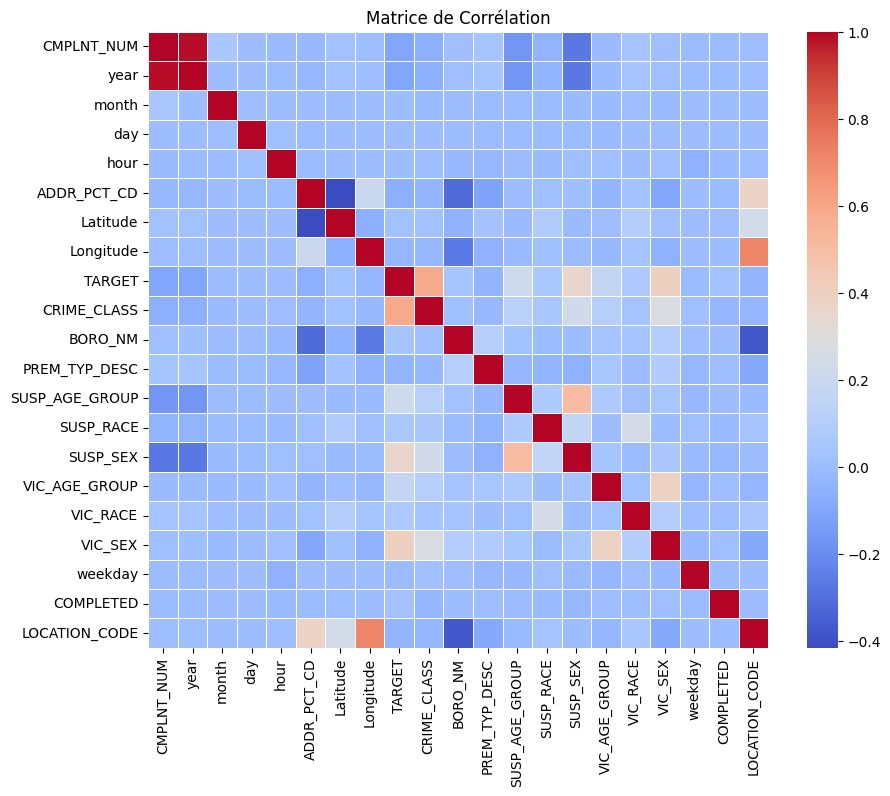

In [29]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matrice de Corrélation")
plt.show()


In [31]:
final_data = num_data[['TARGET', 'year', 'month', 'hour', 'weekday', 'ADDR_PCT_CD', 
                       'CRIME_CLASS', 'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX', 'LOCATION_CODE']]


In [32]:
final_data.to_csv('final_target_data.csv', index=False)